# Quality: Missing and Erroneous Data
This notebook examines the quality of the raw data from NREL. Due to the data size (180 GB), I cannot manually inspect everything. So I have to narrow down my search and try to find the most impactful biases that might be hiding in the data.

The raw data I am working with is a 1-year subset of the full 7.5-year data, which I chose based on highest total file size. Total file size is a proxy for availability - missing files have 0 size, and dead sensors flatline at a constant value which is easily compressed, producing a smaller file. There may be many other problems that are not caught by this filter, but those two issues pose the highest risk.

NREL has provided cleaned versions alongside the raw data. The first thing I did was confirm that obviously bad data was, in fact, removed. This gives me some confidence in the external cleaning process.

## Examine Aggregates
I made preliminary aggregates that assume perfect data - let's see how well those hold up. If a problem is large enough to produce anomalies in aggregates, it is definitely worth investigating. There may be other, more subtle, problems in addition to these, but I'll start there.

In [79]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas_profiling
from pathlib import Path

import src.data.process_matlab as pmat

In [106]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
pd.options.display.max_rows = 10
pd.options.display.max_columns = 100

In [2]:
!pwd

/mnt/c/code/wind/turbulence_spectra/notebooks


In [3]:
# load aggregated data
path = Path('../data/processed/sonic.parquet')
assert path.exists()

In [4]:
sonic = pd.read_parquet(path)

### inconsistent NaN treatment
Some gaps are represented with NaN, but others are missing the whole row. I'll fill each timeseries with NaN for consistency.

In [5]:
# expect 52560 - the number of 10-min periods in a year
sonic.set_index(['timestamp', 'height']).unstack().shape

(51090, 150)

In [6]:
sonic.set_index(['timestamp', 'height']).unstack().asfreq('10min').shape

(52560, 150)

In [7]:
sonic = sonic.set_index(['timestamp', 'height']).unstack().asfreq('10min').stack(dropna=False).reset_index()

### Coarse Univariate Overview

In [8]:
pandas_profiling.ProfileReport(sonic, correlations=None, interactions=None, samples=None).to_notebook_iframe()

**The univariate distributions of the columns prompt a few questions:**
* Are outliers or extreme skew responsible for unreadable histograms of cumulative spectral density metrics?
* why is 'max' bi- or maybe even tri-modal? Maybe an artifact of upstream cleaning process.
* why is nan_count bimodal?
* why is vert_nan_count binary (0 or 12000) but nan_count continuous?

#### Spectral metrics are just extremely skewed - not a quality problem

Values are smoothly distributed and roughly log-normal

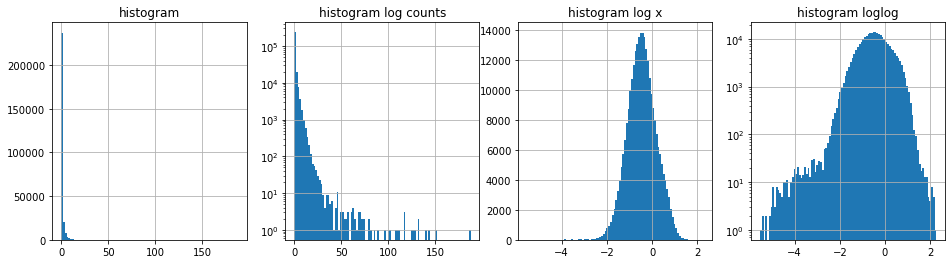

In [26]:
fig, axs = plt.subplots(1,4, figsize=(16,4))
sonic['cum_square_sd_30s'].hist(bins=100, ax=axs[0])
axs[0].set_title('histogram')
sonic['cum_square_sd_30s'].hist(bins=100, log=True, ax=axs[1])
axs[1].set_title('histogram log counts')
sonic['cum_square_sd_30s'].transform(np.log10).hist(bins=100, log=False, ax=axs[2])
axs[2].set_title('histogram log x')
sonic['cum_square_sd_30s'].transform(np.log10).hist(bins=100, log=True, ax=axs[3])
axs[3].set_title('histogram loglog')
plt.show()

seaborn ecdf plot is bugged

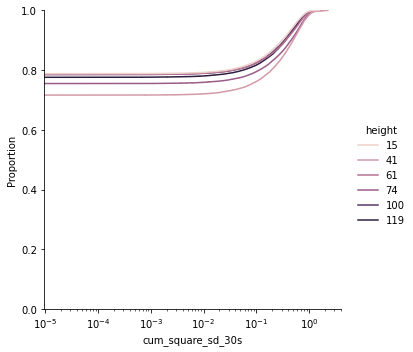

In [61]:
sns.displot(data=sonic, x='cum_square_sd_30s', hue='height', log_scale=True, kind='ecdf')

In [65]:
def log_ecdf(series: pd.Series, ax, label, logx=False, **kwargs):
    sorted_ = series.sort_values()
    ranks = sorted_.rank(pct=True)
    if logx:
        sorted_ = np.log10(sorted_)
    ax.plot(sorted_, ranks, label=label, **kwargs)

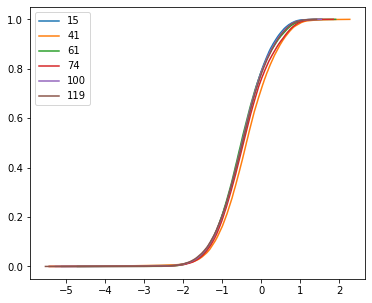

In [71]:
fig, ax = plt.subplots(figsize=(6,5))
grouped = sonic.groupby('height')
for name, grp in grouped:
    log_ecdf(grp['cum_square_sd_30s'], ax, name, logx=True)
ax.legend()

#### Multi-modal Max is due to hitting ceiling of sensor range
Plotting across individual instruments shows this is a universal phenomenon.

With higher bin resolution, can clearly see this is a non-physical artifact. Also note spike of 0 values on height 61.

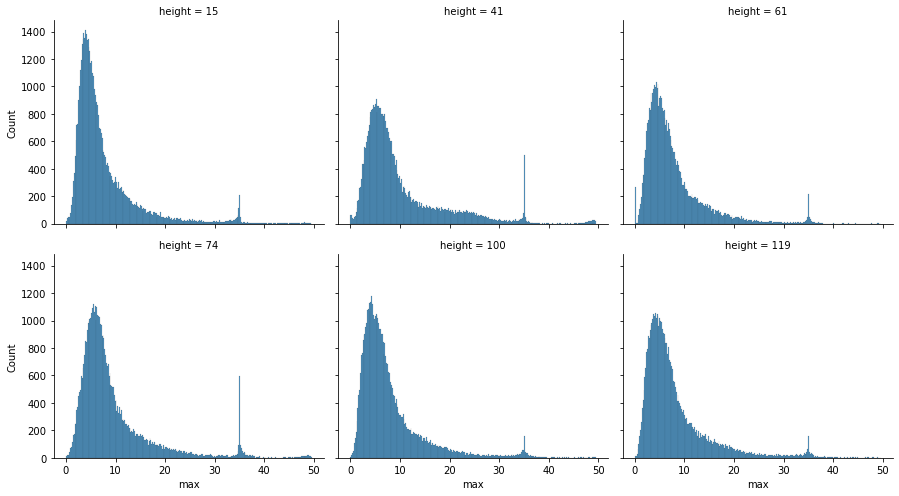

In [76]:
sns.displot(data=sonic, x='max', col='height', col_wrap=3, kind='hist', height=3.5, aspect=1.2)

My instincts said this was a thresholding issue due to the 'pile-up' of counts at a single value in the tail of a distribution. "Wouldn't a threshold have zero counts beyond the threshold?" Important context here is that this 'Max' aggregates a horizontal wind speed column. Sensors measure wind speed in 3 components (x, y, z), and horizontal wind speed is a combination of x and y via pythagoras.

My hypothesis is that the erroneous peak at 35 is due to a component-wise threshold on windspeed. I further hypothesize that the second, much smaller peak just under 50 is actually located at sqrt(35^2 + 35^2), produced when both components are capped.

In [77]:
sonic.groupby('height')['max'].max()

height
15     49.377583
41     49.554045
61     49.080979
74     49.469198
100    49.546973
119    49.497507
Name: max, dtype: float64

In [78]:
(35 **2 + 35 **2) ** 0.5

49.49747468305833

That's pretty strong evidence for a component-wise ceiling, I think. I'm willing to overlook the slight variation around these numbers due to differences in sensor calibration.

Consulting the data documentation confirms a cap, but not quite at that value. This strengthens my confidence that there is a threshold, but undermines confidence that the documentation is accurate. A quick google of the manufacturer spec sheet also shows 30m/s cap. Maybe this isnt the instrument that's actually on the tower? I trust the histogram more than whatever was typed into that table.
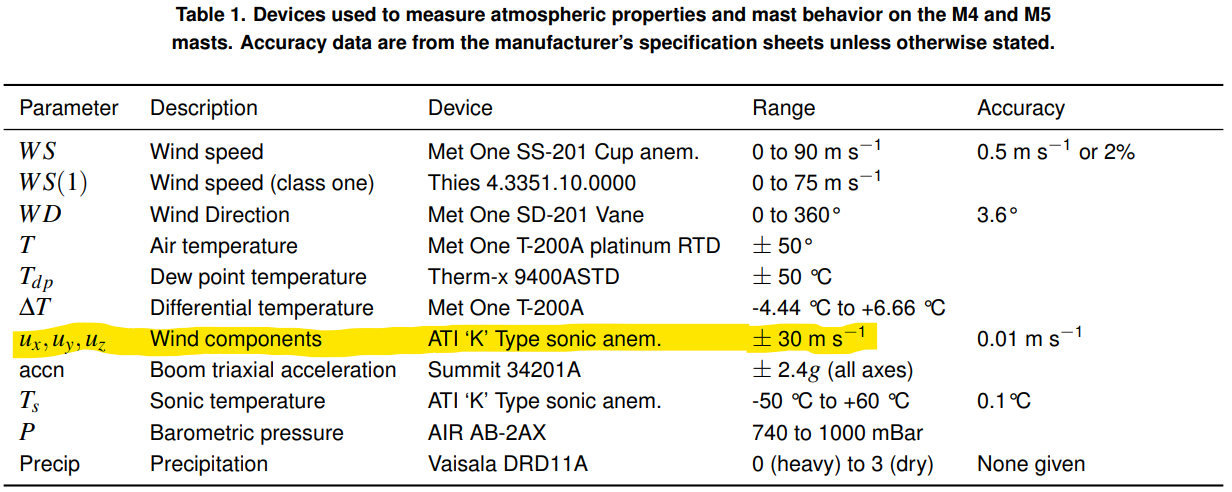

I'll confirm that the raw components are capped at 35:

In [104]:
big_max = sonic.query('max > 40 & nan_count < 100').sample(5)
big_max

timestamp  height  nan_count       mean  diff_mean_sq  \
288030 2019-11-30 01:50:00      15       78.0  21.231343     21.376761   
267961 2019-11-06 20:20:00      41       85.0  12.539208     61.302417   
288066 2019-11-30 02:50:00      15       84.0  20.547528     22.457427   
288192 2019-11-30 06:20:00      15       36.0  20.371456     17.962835   
288115 2019-11-30 04:10:00      41       41.0  24.228016     13.675615   

        diff_mean_cube  cum_square_sd_60s  cum_square_sd_30s  \
288030     1400.163603                NaN                NaN   
267961     2656.593213                NaN                NaN   
288066     1435.704166                NaN                NaN   
288192     1133.589315                NaN                NaN   
288115     1002.570591                NaN                NaN   

        cum_square_sd_10s  cum_square_sd_2s  ...  vert_mean_cube  \
288030                NaN               NaN  ...      -34.566077   
267961                NaN               NaN  ...        0.001324   
288066                NaN               NaN  ...      -24.570070   
288192                NaN               NaN  ...      -26.964590   
288115                NaN               NaN  ...      -23.568459   

        vert_cum_square_sd_60s  vert_cum_square_sd_30s  \
288030                0.354200                0.566554   
267961                0.021734                0.028252   
288066                0.368573                0.592037   
288192                0.224960                0.485370   
288115                0.726153                1.212170   

        vert_cum_square_sd_10s  vert_cum_square_sd_2s    dir_mean  waked_frac  \
288030                1.081438               3.074407  277.251187     0.00000   
267961                0.048323               0.064451    1.709210     0.19225   
288066                1.311771               3.148654  279.838925     0.00000   
288192                1.184567               2.913403  279.270373     0.00000   
288115                2.619488               4.981999  289.165586     0.00000   

             min        max    3s_gust  
288030  7.027012  44.431817  30.131829  
267961  1.504427  41.939233  21.279888  
288066  4.409308  41.147463  29.490370  
288192  3.253321  40.748411  31.688556  
288115  8.000531  40.167331  32.779544  

[5 rows x 27 columns]

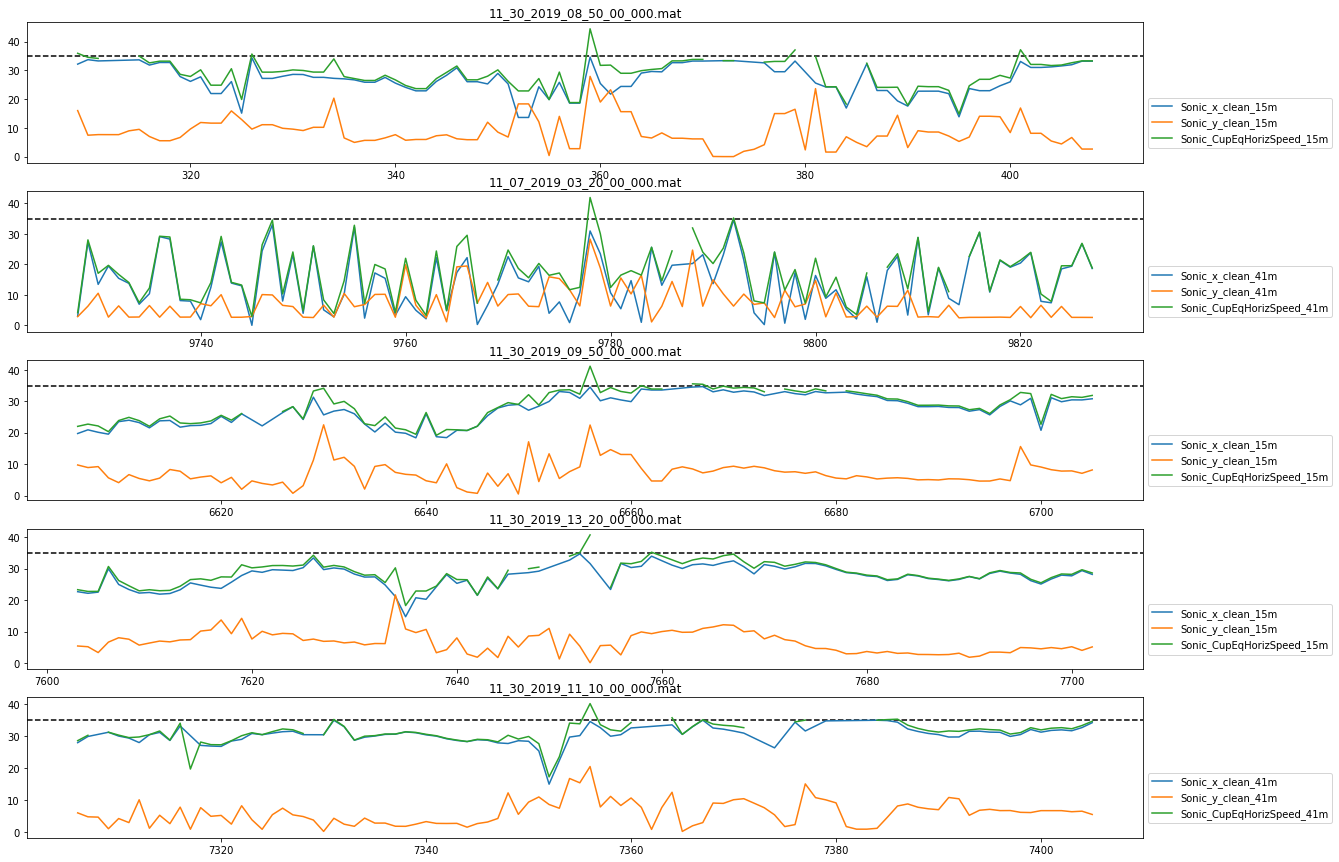

In [116]:
folder = Path('../data/raw/')
fig, axs = plt.subplots(len(big_max), figsize=(20,15))
component_maxes = []

for i, row in enumerate(big_max.iterrows()):
    raw_filename = (row[1]['timestamp'] + pd.Timedelta('7h')).strftime("%m_%d_%Y_%H_%M_%S_000.mat")
    height = row[1]['height']
    cols = [f'Sonic_x_clean_{height}m', f'Sonic_y_clean_{height}m', 'time_UTC', f'Sonic_CupEqHorizSpeed_{height}m']
    
    raw_data = pmat.matlab_to_pandas(folder / raw_filename, col_subset=cols).drop(columns=['time_UTC'])
    component_maxes.append(raw_data[cols[:2]].max())
    
    max_loc = raw_data[cols[-1]].argmax()
    
    axs[i].axhline(35, c='k', linestyle='--')
    raw_data.iloc[max(0, max_loc - 50): min(11999, max_loc + 50),:].abs().plot(ax=axs[i]).legend(bbox_to_anchor=(1, 0.5))
    axs[i].set_title(raw_filename)

In [117]:
pd.concat(component_maxes)

Sonic_x_clean_15m    34.94
Sonic_y_clean_15m    32.30
Sonic_x_clean_41m    35.05
Sonic_y_clean_41m     1.96
Sonic_x_clean_15m    35.05
Sonic_y_clean_15m    26.92
Sonic_x_clean_15m    35.03
Sonic_y_clean_15m    21.67
Sonic_x_clean_41m    34.98
Sonic_y_clean_41m    20.47
dtype: float64

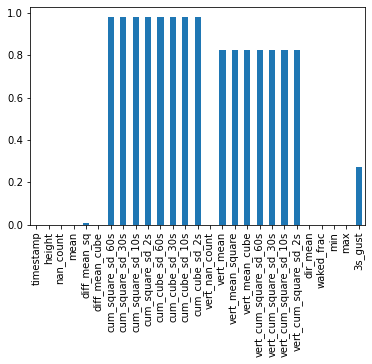

In [126]:
sonic.query('max > 35').isna().mean().plot.bar()

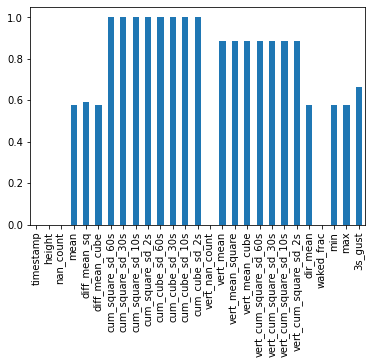

In [127]:
sonic.query('nan_count > 0').isna().mean().plot.bar()

In [128]:
sonic.query('nan_count > 0').shape

(33560, 27)

This dataset contains multiple sensors, one at each height. Some problems (like with data collection) effect all sensors simultaneously. These are high-impact issues, so I'll check those first.

In [29]:
pandas_profiling.ProfileReport(sonic.query('height == 100').set_index('timestamp').drop(columns=['height']), correlations=None, interactions=None, samples=None).to_widgets()

In [33]:
pandas_profiling.ProfileReport(sonic.pivot(index='timestamp', columns='height', values='mean'), title='All sensors, one column (mean)', explorative=True, correlations=None, interactions=None, samples=None).to_notebook_iframe()

In [26]:
import missingno

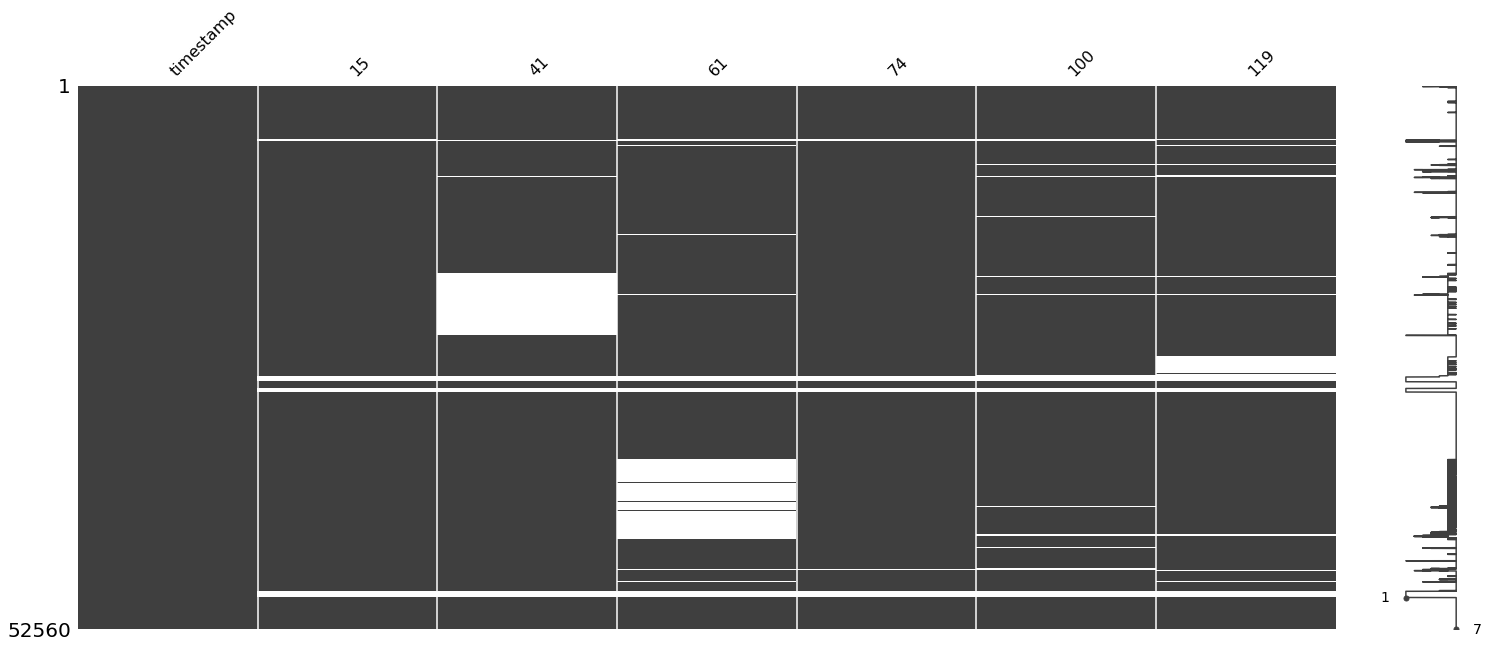

In [30]:
missingno.matrix(sonic.pivot(index='timestamp', columns='height', values='mean').reset_index())

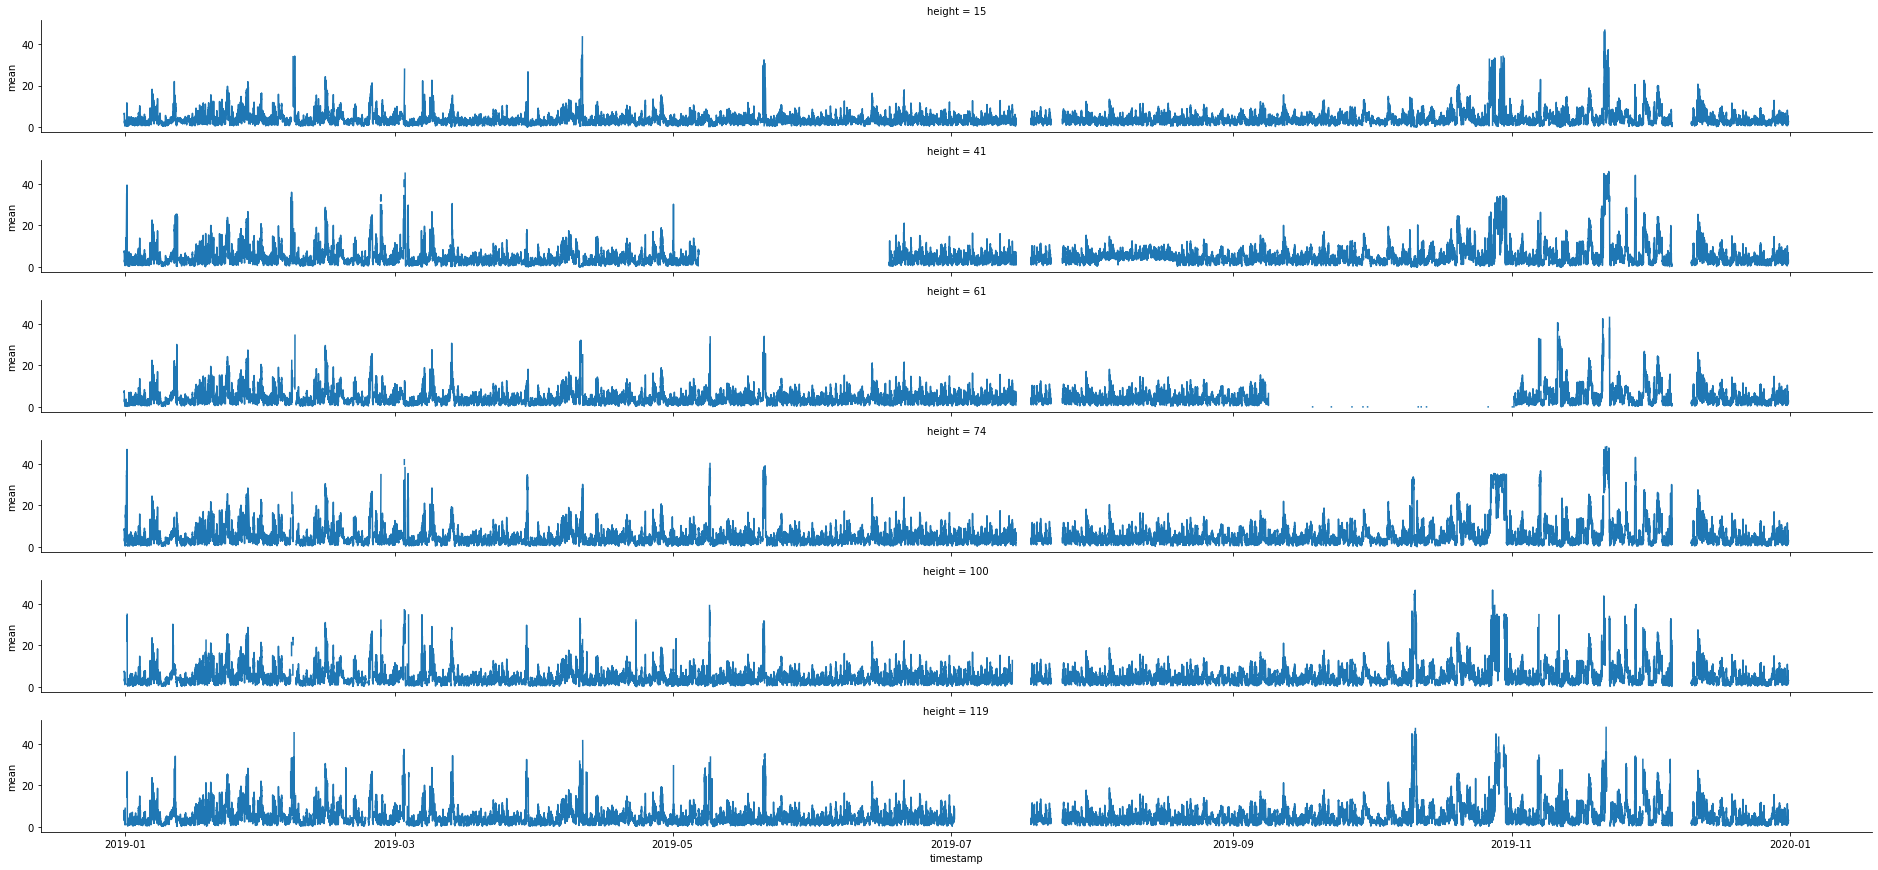

In [37]:
sns.relplot(data=sonic, x='timestamp', y='mean', row='height', kind='line', height=2, aspect=13)

Also, height 41, in August, looks like it had some kind of step change no other series had. I'll check for other correlation changes in time.

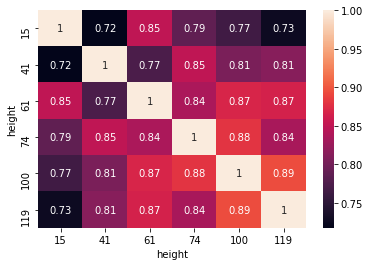

In [45]:
# all-time correlation matrix of mean by height
# expect heights to correlate better to closer neighbors
sns.heatmap(sonic.pivot(index='timestamp', columns='height', values='mean').corr(), annot=True)
plt.show()

To check correlation over time, I'll plot rolling, windowed pearson correlation. Heights 74 and 100 have the best coverage, so I'll use one of them a a benchmark, then check vs the other.

In [50]:
sonic.pivot(index='timestamp', columns='height', values='mean').head(3)

height                    15        41        61        74        100  \
timestamp                                                               
2018-12-31 17:00:00  6.392259  7.187378  7.279952  8.192143  7.341598   
2018-12-31 17:10:00  6.597348  7.154021  7.041983  7.849541  6.816752   
2018-12-31 17:20:00  6.491059  7.727798  7.754189  8.696105  7.504780   

height                    119  
timestamp                      
2018-12-31 17:00:00  7.741269  
2018-12-31 17:10:00  7.233263  
2018-12-31 17:20:00  7.899411

In [126]:
window_days = 30
coverage_threshold = 0.9
roll_corr = sonic.pivot(index='timestamp', columns='height', values='mean').rolling(str(window_days) +'d', min_periods=int(6*24*window_days * coverage_threshold)).corr().unstack().dropna(how='all')
roll_corr.head(3)

height               15                                        41        \
height               15        41        61  74  100 119       15   41    
timestamp                                                                 
2019-01-27 17:00:00  1.0       NaN       NaN NaN NaN NaN       NaN  NaN   
2019-01-27 17:10:00  1.0       NaN  0.928247 NaN NaN NaN       NaN  1.0   
2019-01-27 17:20:00  1.0  0.818033  0.928249 NaN NaN NaN  0.818033  1.0   

height                             ... 100             119                      
height                    61  74   ... 61  74  100 119 15  41  61  74  100 119  
timestamp                          ...                                          
2019-01-27 17:00:00       NaN NaN  ... NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  
2019-01-27 17:10:00       NaN NaN  ... NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  
2019-01-27 17:20:00  0.797253 NaN  ... NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  

[3 rows x 36 columns]

In [127]:
roll_corr.columns.rename(['height1', 'height2'], inplace=True)

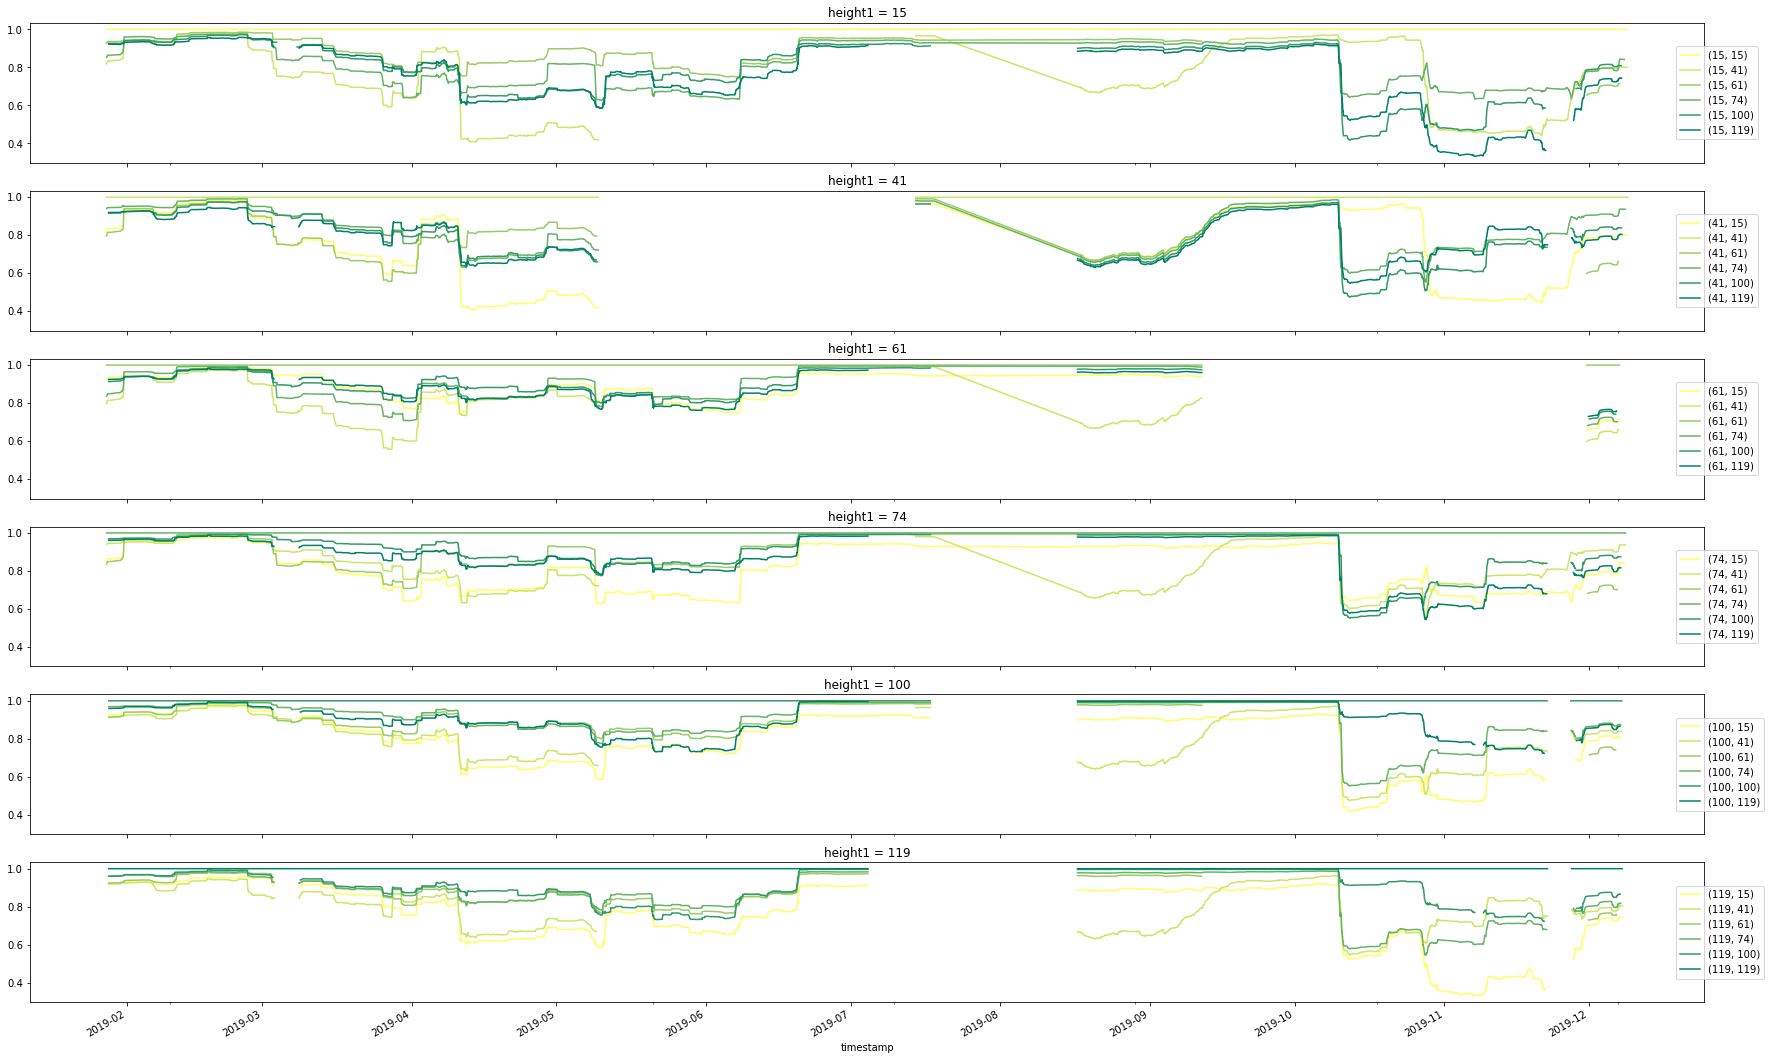

In [149]:
fig, axs = plt.subplots(nrows=6, ncols=1, sharex=True, sharey=True, figsize=(30,20))
for i, height in enumerate(roll_corr.columns.get_level_values(level=0).unique()):
    roll_corr.loc[:, pd.IndexSlice[height, :]].plot(ax=axs[i], legend=False, cmap='cividis')
    axs[i].set_title(f'height1 = {height}')
    axs[i].legend(loc='center left', bbox_to_anchor=(0.98, 0.5))
plt.show()

In [123]:
roll_corr = roll_corr.unstack().rename('corr').reset_index()
roll_corr.head(3)

height1  height2           timestamp  corr
0       15       15 2019-01-27 17:00:00   1.0
1       15       15 2019-01-27 17:10:00   1.0
2       15       15 2019-01-27 17:20:00   1.0

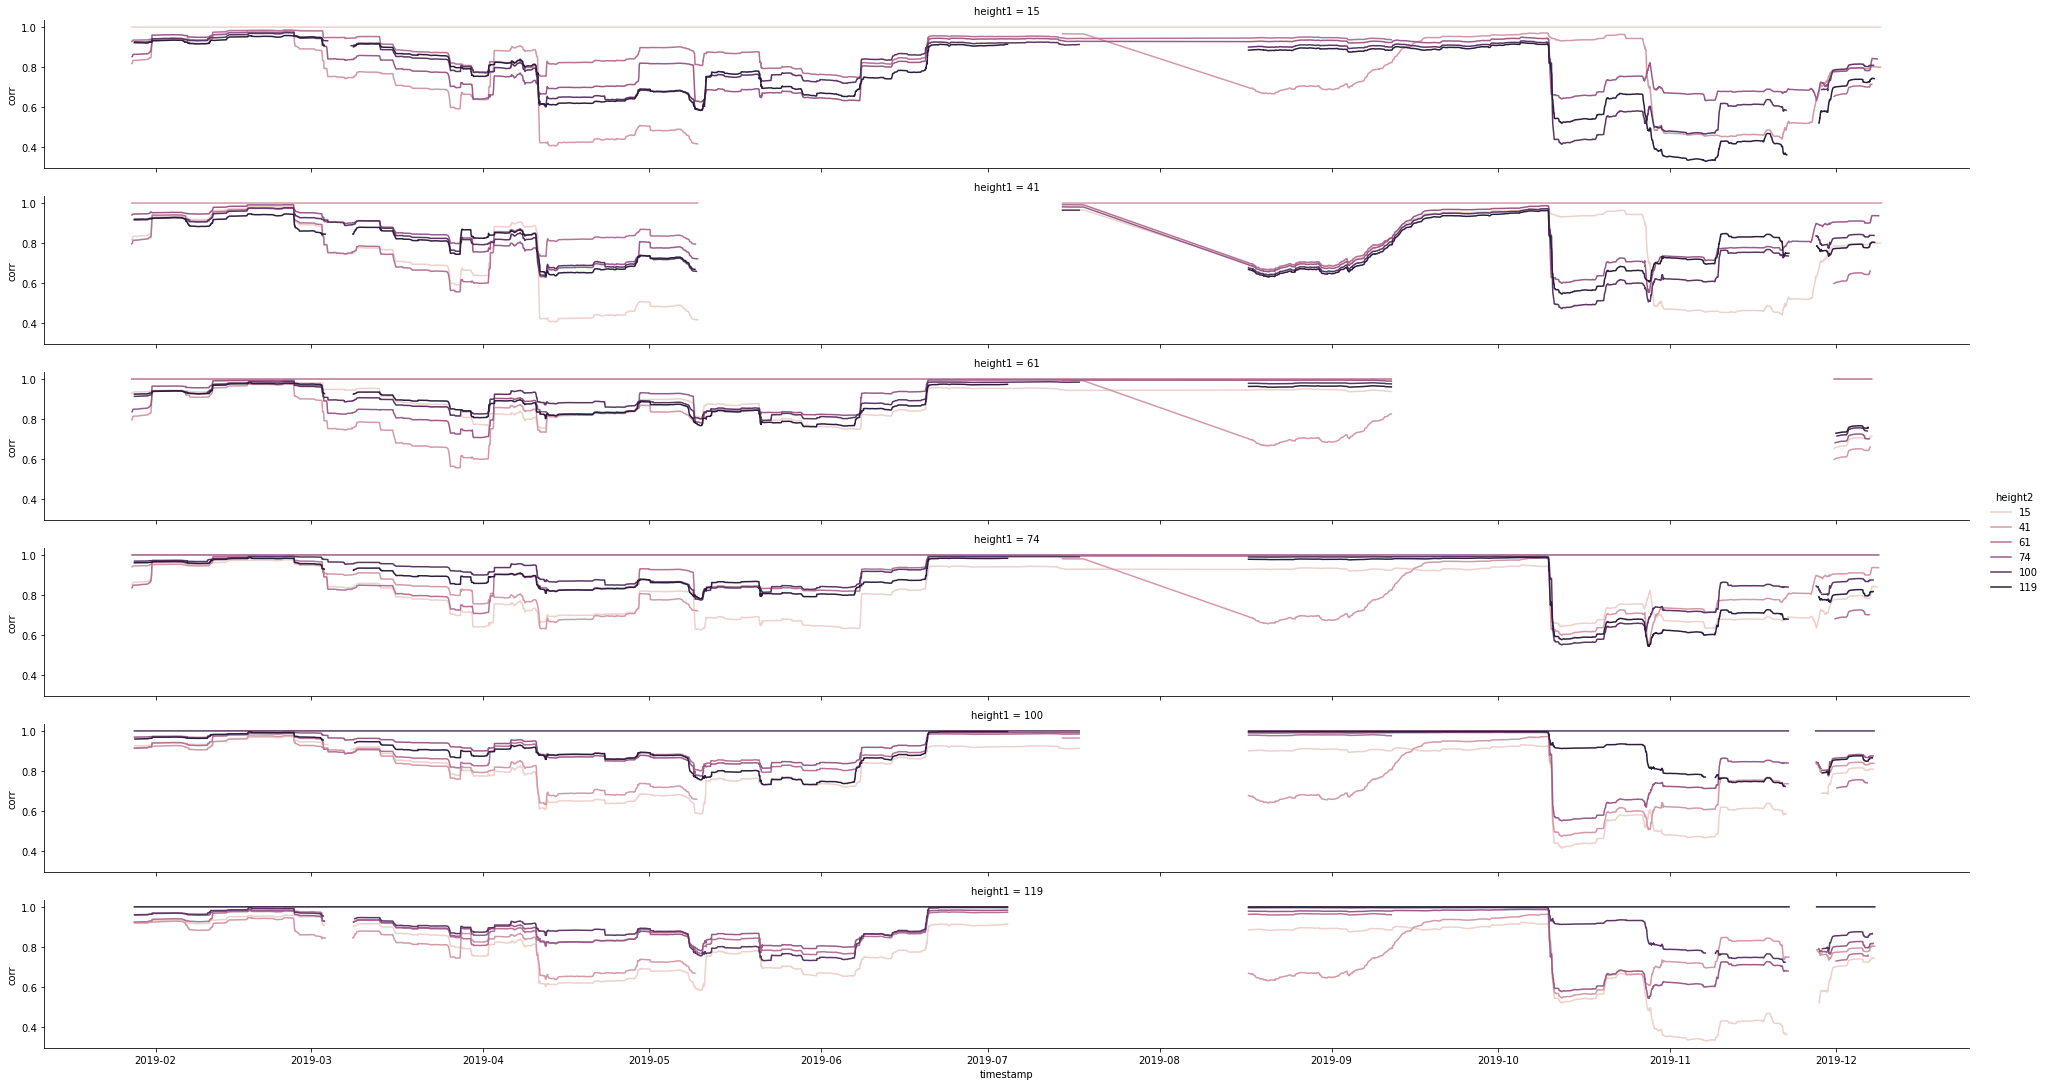

In [124]:
sns.relplot(data=roll_corr, x='timestamp', y='corr', kind='line', hue='height2', row='height1', height=2.5, aspect=11)

In [6]:
heights = sonic['height'].unique()
heights

array([119, 100,  74,  61,  41,  15])

In [7]:
s119 = sonic.query('height == 119').drop(columns='height').set_index('timestamp', drop=True)
s119.head(3)

nan_count      mean  diff_mean_sq  diff_mean_cube  \
timestamp                                                                
2018-12-31 17:00:00          0  7.741269      0.278593        6.444512   
2018-12-31 17:10:00          0  7.233263      0.477996       10.375038   
2018-12-31 17:20:00          0  7.899411      0.279826        6.436817   

                     cum_square_sd_60s  cum_square_sd_30s  cum_square_sd_10s  \
timestamp                                                                      
2018-12-31 17:00:00           0.175206           0.221440           0.249491   
2018-12-31 17:10:00           0.373757           0.418074           0.445737   
2018-12-31 17:20:00           0.173689           0.219780           0.251649   

                     cum_square_sd_2s  cum_cube_sd_60s  cum_cube_sd_30s  ...  \
timestamp                                                                ...   
2018-12-31 17:00:00          0.270052         6.103863         6.372773  ...   
2018-12-31 17:10:00          0.466931        10.097132        10.295073  ...   
2018-12-31 17:20:00          0.270449         6.068854         6.338365  ...   

                     vert_nan_count  vert_mean  vert_mean_square  \
timestamp                                                          
2018-12-31 17:00:00               0  -0.116775          0.103902   
2018-12-31 17:10:00               0  -0.133584          0.157386   
2018-12-31 17:20:00               0  -0.163695          0.103526   

                     vert_mean_cube  vert_cum_square_sd_60s  \
timestamp                                                     
2018-12-31 17:00:00       -0.007359                0.018279   
2018-12-31 17:10:00       -0.025958                0.040330   
2018-12-31 17:20:00       -0.033056                0.016517   

                     vert_cum_square_sd_30s  vert_cum_square_sd_10s  \
timestamp                                                             
2018-12-31 17:00:00                0.034086                0.060655   
2018-12-31 17:10:00                0.063172                0.104504   
2018-12-31 17:20:00                0.029382                0.051968   

                     vert_cum_square_sd_2s   dir_mean  waked_frac  
timestamp                                                          
2018-12-31 17:00:00               0.080494  22.387435         0.0  
2018-12-31 17:10:00               0.128307  18.884868         0.0  
2018-12-31 17:20:00               0.068729  19.204617         0.0  

[3 rows x 22 columns]

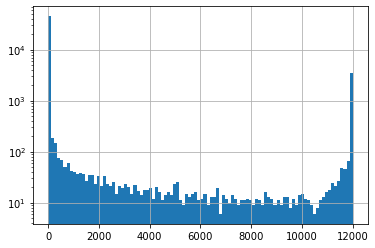

In [8]:
s119['nan_count'].hist(bins=100, log=True)

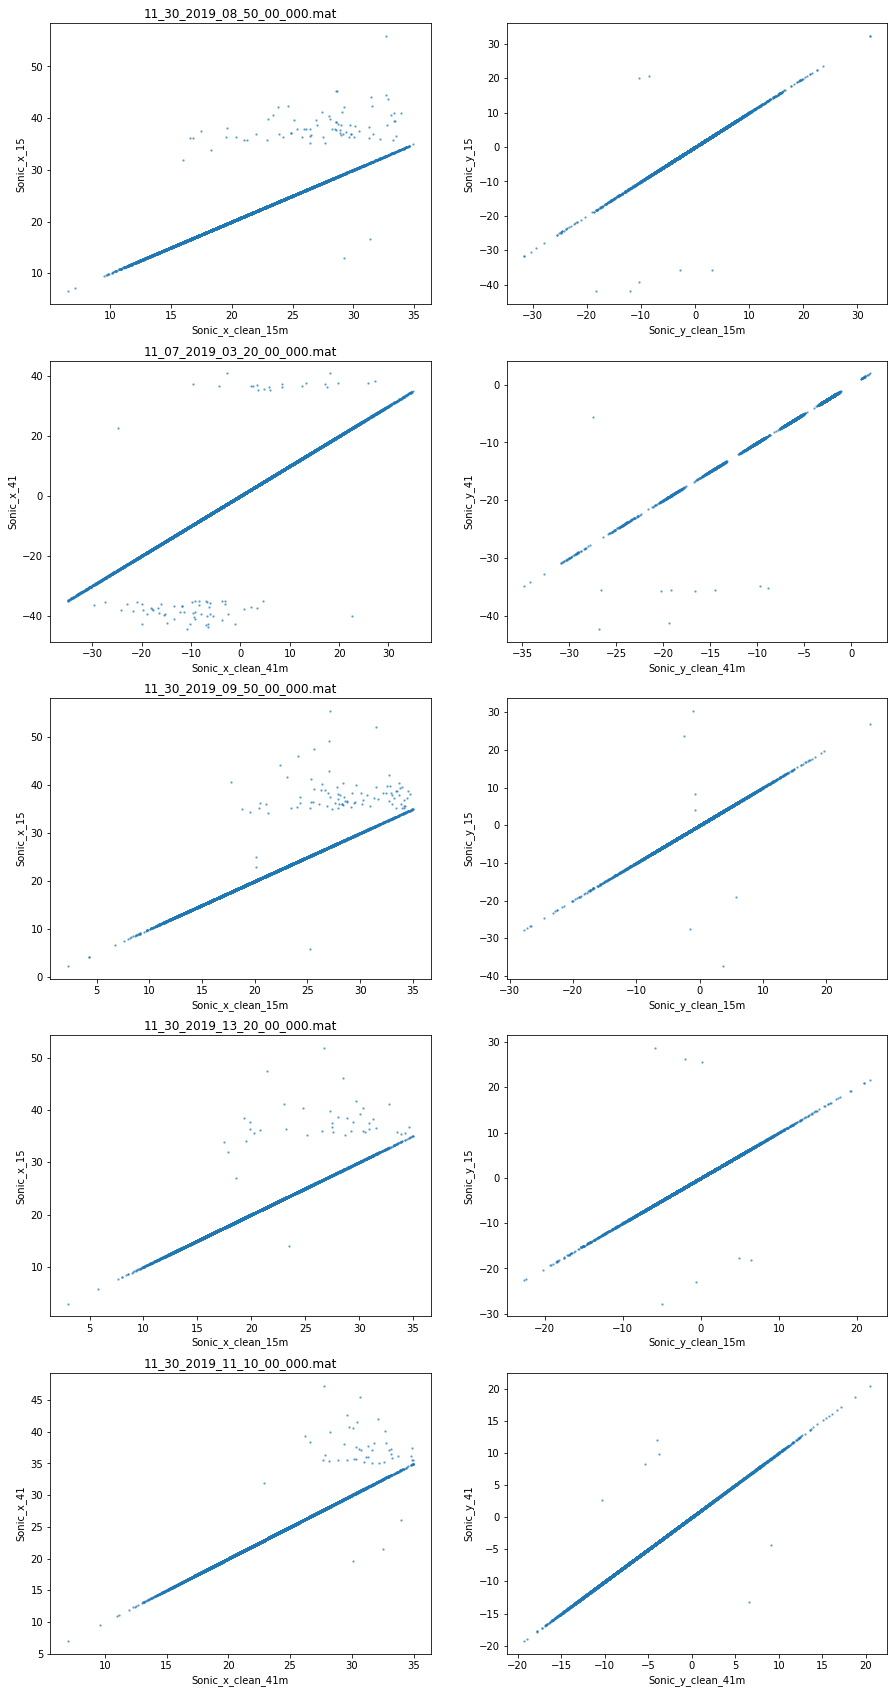

In [122]:
folder = Path('../data/raw/')
fig, axs = plt.subplots(len(big_max), 2, figsize=(15,30))

for i, row in enumerate(big_max.iterrows()):
    raw_filename = (row[1]['timestamp'] + pd.Timedelta('7h')).strftime("%m_%d_%Y_%H_%M_%S_000.mat")
    height = row[1]['height']
    cols = [f'Sonic_x_clean_{height}m', f'Sonic_y_clean_{height}m', f'Sonic_x_{height}', f'Sonic_y_{height}', 'time_UTC', f'Sonic_CupEqHorizSpeed_{height}m']
    
    raw_data = pmat.matlab_to_pandas(folder / raw_filename, col_subset=cols).drop(columns=['time_UTC'])
    raw_data.plot.scatter(x=cols[0], y=cols[2], s=2, alpha=0.5, ax=axs[i,0])
    raw_data.plot.scatter(x=cols[1], y=cols[3], s=2, alpha=0.5, ax=axs[i,1])
    axs[i,0].set_title(raw_filename)